In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

import rdkit
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs



#randomforestclassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


from mordred import Calculator, descriptors

#PCA
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

#compute accuracy
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef

,SMILES,ALDH1_inhibition,ROMol,original_index
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1,,0
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1,,1
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1,,2
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1,,3
4,CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21,1,,4
...,...,...,...,...
1995,C/C(=N\NC(=S)Nc1ccc(F)cc1)C1CC1,1,,1995
1996,COC(=O)c1c(NC(C)=O)sc2c1CCCCC2,1,,1996
1997,O=C(CCl)NC1CCCc2ccccc21,1,,1997
1998,COc1ccc(-n2c(SCC(=O)N3CCCCC3C)nnc2-c2cccnc2)cc1,1,,1998

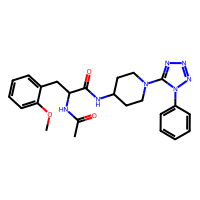
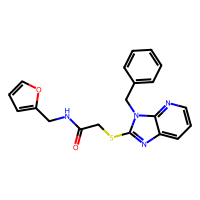
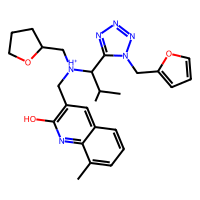
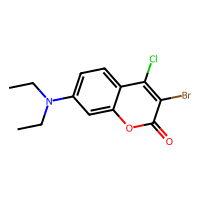
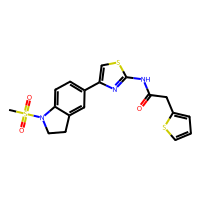
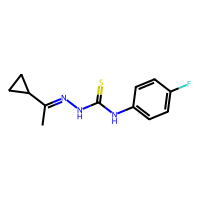
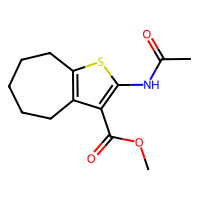
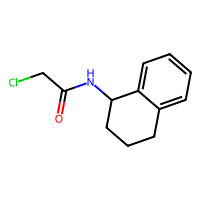
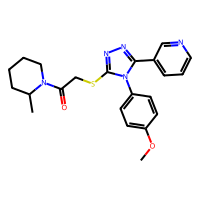
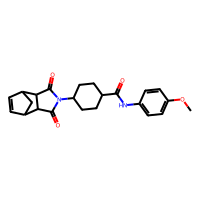

In [2]:
df_tested_molecules1 = pd.read_csv('tested_molecules-1.csv')
df_tested_molecules2 = pd.read_csv('tested_molecules_v2.csv')

df = pd.concat([df_tested_molecules1, df_tested_molecules2], ignore_index=True)
df_molecules = df.copy(deep=True)
smiles_good_inhibitor = df[df['ALDH1_inhibition'] == 1].reset_index()
smiles_bad_inhibitor = df[df['ALDH1_inhibition'] == 0].reset_index()

PandasTools.AddMoleculeColumnToFrame(df_molecules, smilesCol='SMILES')
df_molecules['original_index'] = df_molecules.index
df_molecules

In [3]:
def plot_mol (smiles_df, molecule_index):
    smiles = smiles_df['SMILES'][molecule_index]
    mol =Chem.MolFromSmiles(smiles)
    Draw.MolToMPL(mol, size=(200, 200))


In [4]:
def plot_list_mol(smiles_df):
    mol_list = []
    for smiles in smiles_df:
        for smiles in smiles_df['SMILES']:    # assuming your column is called Smiles
            mol = Chem.MolFromSmiles(smiles)
            Chem.SanitizeMol(mol,sanitizeOps=Chem.SANITIZE_SYMMRINGS|Chem.SANITIZE_SETCONJUGATION|Chem.SANITIZE_SETHYBRIDIZATION)
            mol.Compute2DCoords()
            mol_list.append(mol)
            Draw.MolToMPL(mol, size=(200, 200))

In [5]:
def rdkit_numpy_convert(fp):
    output = []
    for f in fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [6]:
#split fingerprint data set in training and test set
seed = 42
X_train, X_test, y_train, y_test = train_test_split(df_molecules, df_molecules['ALDH1_inhibition'], stratify=df_molecules['ALDH1_inhibition'],test_size=0.25, random_state=seed)

X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [7]:
X_train_fp = rdkit_numpy_convert([AllChem.GetMorganFingerprintAsBitVect(x,3) for x in X_train['ROMol']])
X_test_fp = rdkit_numpy_convert([AllChem.GetMorganFingerprintAsBitVect(x,3) for x in X_test['ROMol']])
y_train_fp = y_train['ALDH1_inhibition'].copy()
y_test_fp = y_test['ALDH1_inhibition'].copy()

In [8]:
#create 10 folds
cv = StratifiedKFold(n_splits=5)

In [9]:
# create grid search dictionary
param_grid = {"max_features": [X_train_fp.shape[1] // 10, X_train_fp.shape[1] // 7, X_train_fp.shape[1] // 5, X_train_fp.shape[1] // 3], 
              "n_estimators": [100, 250, 500]}

In [10]:
m = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=2, cv=cv, verbose=1)


In [11]:
m.fit(X_train_fp, y_train_fp)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_features': [204, 292, 409, 682],
                         'n_estimators': [100, 250, 500]},
             verbose=1)

In [12]:
m.cv_results_['mean_test_score']

array([0.79      , 0.794     , 0.80066667, 0.78933333, 0.79466667,
       0.79      , 0.79733333, 0.79333333, 0.79666667, 0.79      ,
       0.79266667, 0.78933333])

In [13]:

m.cv_results_['params']

[{'max_features': 204, 'n_estimators': 100},
 {'max_features': 204, 'n_estimators': 250},
 {'max_features': 204, 'n_estimators': 500},
 {'max_features': 292, 'n_estimators': 100},
 {'max_features': 292, 'n_estimators': 250},
 {'max_features': 292, 'n_estimators': 500},
 {'max_features': 409, 'n_estimators': 100},
 {'max_features': 409, 'n_estimators': 250},
 {'max_features': 409, 'n_estimators': 500},
 {'max_features': 682, 'n_estimators': 100},
 {'max_features': 682, 'n_estimators': 250},
 {'max_features': 682, 'n_estimators': 500}]

## Mordred descriptors model

In [14]:
#Split data into Test data set and training data set before doing anything.
mordred_calc = Calculator(descriptors, ignore_3D=True)

X_train_mor =  mordred_calc.pandas(mol for mol in X_train['ROMol'])
X_train_mor = X_train_mor.select_dtypes(include=['float64', 'int64', 'float'])

X_test_mor = mordred_calc.pandas(mol for mol in X_test['ROMol'])
X_test_mor = X_test_mor[X_train_mor.columns]

y_train_mor = y_train['ALDH1_inhibition'].copy()
y_test_mor = y_test['ALDH1_inhibition'].copy()

1500it [01:19, 18.85it/s]
500it [00:29, 16.78it/s]


In [15]:
 #X_train_mor = np.concatenate((X_train_fp, X_train_mor), axis=1)
#X_test_mor = np.concatenate((X_test_fp, X_test_mor), axis=1)

In [ ]:
# Create correlation matrix
corr_matrix = X_train_mor.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X_train_mor.drop(to_drop, axis=1, inplace=True)
X_test_mor.drop(to_drop, axis=1, inplace=True)
X_train_mor.shape

In [16]:
#create 10 folds
cv = StratifiedKFold(n_splits=5)

In [17]:
# create grid search dictionary
param_grid = {"max_features": [X_train_mor.shape[1] // 10, X_train_mor.shape[1] // 7, X_train_mor.shape[1] // 5, X_train_mor.shape[1] // 3], 
              "n_estimators": [100, 250, 500]}

In [18]:
m_mordred = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=2, cv=cv, verbose=1)

In [19]:
# run model building
m_mordred.fit(X_train_mor, y_train_mor)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_features': [317, 453, 634, 1057],
                         'n_estimators': [100, 250, 500]},
             verbose=1)

In [20]:
m_mordred.cv_results_['mean_test_score']

array([0.79266667, 0.79133333, 0.79666667, 0.79733333, 0.792     ,
       0.79      , 0.79866667, 0.79333333, 0.79133333, 0.78533333,
       0.78933333, 0.79133333])

In [21]:
m_mordred.cv_results_['params']

[{'max_features': 317, 'n_estimators': 100},
 {'max_features': 317, 'n_estimators': 250},
 {'max_features': 317, 'n_estimators': 500},
 {'max_features': 453, 'n_estimators': 100},
 {'max_features': 453, 'n_estimators': 250},
 {'max_features': 453, 'n_estimators': 500},
 {'max_features': 634, 'n_estimators': 100},
 {'max_features': 634, 'n_estimators': 250},
 {'max_features': 634, 'n_estimators': 500},
 {'max_features': 1057, 'n_estimators': 100},
 {'max_features': 1057, 'n_estimators': 250},
 {'max_features': 1057, 'n_estimators': 500}]

In [22]:
#let model predict
pred_mordred = m_mordred.predict(X_test_mor)

In [23]:
accuracy_score(y_test_mor, pred_mordred)

0.826

In [24]:
matthews_corrcoef(y_test_mor, pred_mordred)

0.576357635926438

In [25]:
cohen_kappa_score(y_test_mor, pred_mordred)

0.5751953125

,index,SMILES,ALDH1_inhibition,ROMol,original_index
7,1713,C=C1C(=O)O[C@H]2[C@H]1CC/C(C)=C/CC[C@@]1(C)O[C...,1,,1713
118,1788,Cc1ccccc1Oc1ccc(NC(=O)C2CC=CCC2C(=O)[O-])cc1,1,,1788
38,1862,CCOC(=O)c1sc(NC(=O)C2C3C=CC(C3)C2C(=O)[O-])nc1C,1,,1862
382,1916,CCOC(=O)C1=C(C)C(c2cccc(Oc3ccccc3)c2)NC(S)=[NH+]1,1,,1916
160,1779,CC(=O)c1nc(N2C(=O)C3CC=C(C)CC3C2=O)sc1C,1,,1779
...,...,...,...,...,...
22,1899,Cc1ccc(N2C(=O)CC(N([O-])C3CC(=O)N(c4ccc(C)cc4)...,1,,1899
480,563,Cc1ccc(-n2c(SCC(=O)c3c(N)n(C)c(=O)n(C)c3=O)nc3...,0,,563
66,1943,Cc1ccc(CCNC(=O)C2CCN(S(=O)(=O)N3CCCC3)CC2)cc1,1,,1943
424,1906,Cc1cc(C)n(-c2cc(N3CCN(C(=O)c4cccc(F)c4)CC3)ccc...,1,,1906

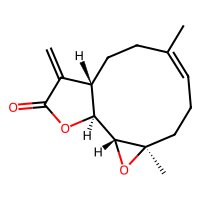
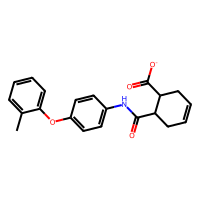
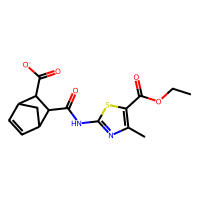
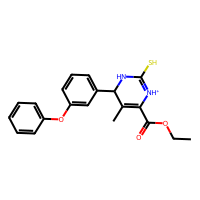
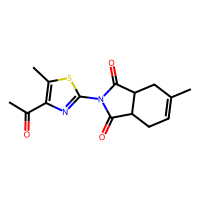
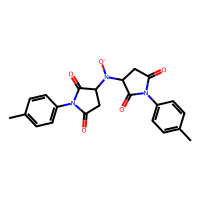
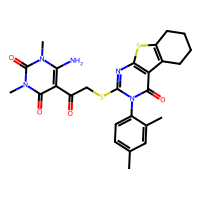
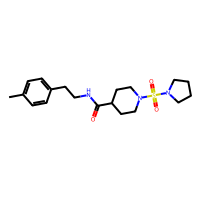
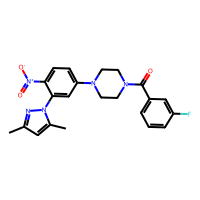
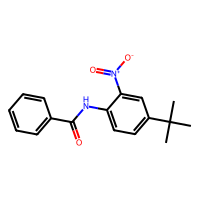

In [26]:
pred_prob_mordred = m_mordred.predict_proba(X_test_mor)

df_pred_prob_mordred = pd.DataFrame(data=pred_prob_mordred, columns=['not inhibitor', 'inhibitor'])
df_pred_prob_mordred['molecule_index'] = df_pred_prob_mordred.index
df_pred_prob_mordred = df_pred_prob_mordred.sort_values(by='inhibitor', ascending=False)

top100_predicted = X_test.iloc[df_pred_prob_mordred['molecule_index'].iloc[0:100]].copy()
top100_labels = y_test.iloc[df_pred_prob_mordred['molecule_index'].iloc[0:100]].copy()
PandasTools.AddMoleculeColumnToFrame(top100_predicted, smilesCol='SMILES')
top100_predicted

In [27]:
top100_labels[top100_labels['ALDH1_inhibition']==1]['ALDH1_inhibition'].shape

(73,)